In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sys
import zipfile

sys.path.append('..')
from scripts.project_functions import load_n_process as lnp
from scripts.project_functions import load_and_process_brandon as lnpb

In [2]:
df = lnp("C:/Users/Don/Desktop/FiresNEW.csv")
#CHANGE PATH TO WHERE YOU DOWNLOAD THE FILE. FILE IS TOO LARGE TO USE IN GITHUB

# How has the location or frequency of wildfires in the US changed in the past 30 years, and does this show a potential correlation with climate change (ie. increasing temperatures)?

To answer the above question, I first decided to view the northernmost fire every year and plot it as a time series. There is chance that only the frequency of these fires in northernmost regions would have increased, which would not show a trend in this plot, but nonetheless, here is the result:


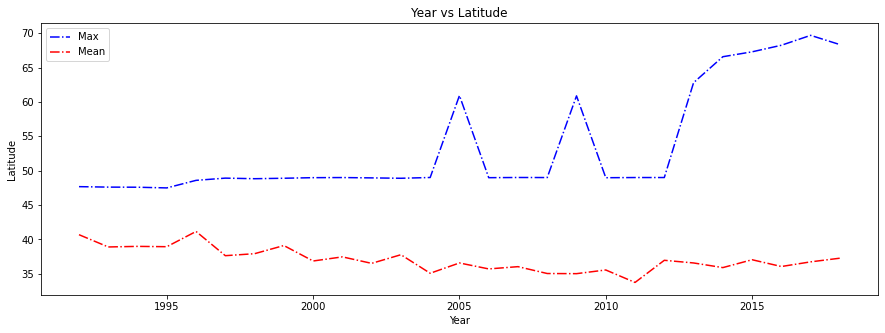

In [5]:
# Take northernmost fire every year and mean fire latitude and plot it versus the year
year_p_lat = df[['FIRE_YEAR', 'LATITUDE']].copy()
max_lat = year_p_lat.groupby(['FIRE_YEAR']).max()
mean_lat = year_p_lat.groupby(['FIRE_YEAR']).mean()
max_lat.reset_index(inplace=True)
mean_lat.reset_index(inplace=True)

latdf = pd.merge(mean_lat, max_lat, how = 'outer', on="FIRE_YEAR")
latdf.rename(columns = {'LATITUDE_x':'MEAN_LAT', 'LATITUDE_y':'MAX_LAT'}, inplace = True)

dimensions = (15, 5)
f, ax = plt.subplots(figsize=dimensions)
ax.plot(latdf['FIRE_YEAR'], latdf['MAX_LAT'], color="blue", label="Max", linestyle="dashdot")
ax.plot(latdf['FIRE_YEAR'], latdf['MEAN_LAT'], color="red", label="Mean", linestyle="dashdot")
plt.title('Year vs Latitude')
plt.xlabel("Year")
plt.ylabel("Latitude")
ax.legend()
plt.show()

There are a few conclusions I can make from the above plot regarding my data:
​   
    
    - On average, the mean latitude of forest fires has not only not shown an upwards trend over the course of the 30 years we are looking at, it has actually slightly decreased.
    - The maximum latitude every year seems to have increased, but may be due to one off events in northern regions such as Alaska, and therefore might pain the wrong picture.
    - This leads me to make a loose assumption that the mean fire location could have lowered due to the increase in frequency fires in the southernmost parts of the country, while climate-change induced changes in temperature may be less noticeable in northernmost states.

Based in my last point above, it would be interesting to plot the change of frequency of fires in the suthernmost regious of the US, and compare them to the same index but for the northernmost states.

Text(10.436603751187086, 0.5, 'Fire Frequency')

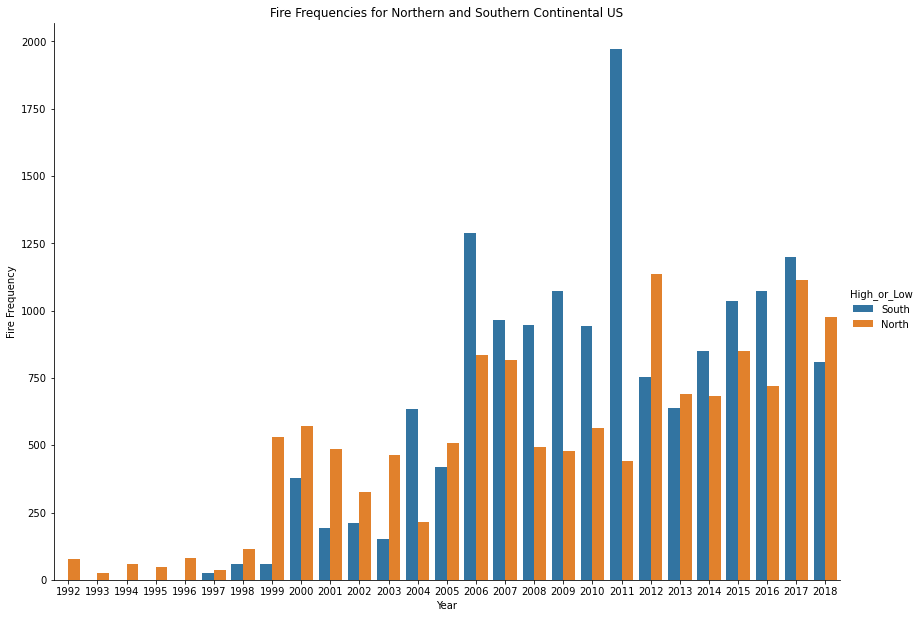

In [6]:
# Take the lower 30% latitude fires' frequency every year, and plot it on the same graph as the upper 30% latitude fires.
low = df[['FIRE_YEAR', 'LATITUDE']].copy()
high = df[['FIRE_YEAR', 'LATITUDE']].copy()

#I will only take values in continental US, to allow for a greater number of fires included in the "high" dataset. AKA 49th parallel down (Canada), and 24th up (Key West).
lat_range = 49-24
lowlimit = 24+lat_range*0.3
highlimit = 24+lat_range*0.7

low.drop(low[(low['LATITUDE']>lowlimit)].index, inplace=True)
high.drop(high[(high['LATITUDE']<highlimit)].index, inplace=True)

low.rename(columns = {'LATITUDE':'FREQ'}, inplace = True)
high.rename(columns = {'LATITUDE':'FREQ'}, inplace = True)

low_freq = low.groupby(['FIRE_YEAR']).count()
low_freq.reset_index(inplace=True)
high_freq = high.groupby(['FIRE_YEAR']).count()
high_freq.reset_index(inplace=True)

high_and_low = pd.merge(low_freq, high_freq, how = 'outer', on="FIRE_YEAR")
high_and_low.rename(columns = {'FREQ_x':'South'}, inplace = True)
high_and_low.rename(columns = {'FREQ_y':'North'}, inplace = True)

melt = pd.melt(high_and_low, id_vars="FIRE_YEAR", var_name="High_or_Low", value_name="Frequency")

sns.catplot(x='FIRE_YEAR', y='Frequency', hue='High_or_Low', data=melt, kind='bar', height=8.27, aspect=11.7/8.27)
plt.title('Fire Frequencies for Northern and Southern Continental US')
plt.xlabel('Year')
plt.ylabel('Fire Frequency')



### As we can see above, there are four main observations I can draw from this visualization:

1. In the first ten years of the data, southern fires were either less recorded, or had a lower frequency than northern.
2. From roughly 2004 onwards, southern continental US fires seem to go through a sudden spike in frequency, and greatly beat the amount of fires in the top 30% of the country.
3. My previous hypothersis that "the mean fire location could have lowered due to the increase in frequency fires in the southernmost parts of the country" seems to be supported by this data.
### Most importantly:

4. **The frequency of fires in continental US again shows a visible increase in the past 30 years.**
   
   
   
   
While we have found some information relating to the change in fire location across the US, we have also hit somewhat of a roadblock. While there may be more in depth analyses possible with the fire frequency, for the purposes of noticing location-bases trends it is best to not dive too deeply in other variables. Before making one last hopefully all-emcompassing visual I will travel down one more road: Fire duration.

Because the fire frequency index gave some insight into possible patterns in the location of fires, looking at the duration of individual fires could hopefully show a similar pattern, solidifying our ideas.




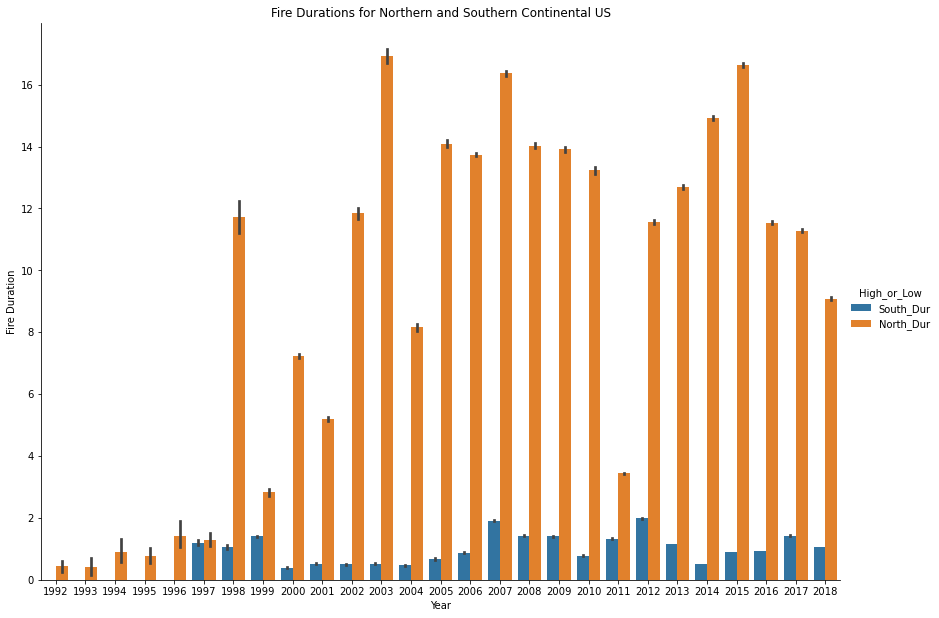

In [7]:
# modify duration plot to show both south and north fires

duration = df[['FIRE_YEAR', 'LATITUDE', 'DISCOVERY_DATE', 'CONT_DATE']].copy()

indexNames = duration[ duration['CONT_DATE'] == '9999-12-31 0:00:00' ].index
duration.drop(indexNames , inplace=True)

duration['Disc_Datetime'] = (pd.to_datetime(duration['DISCOVERY_DATE'])).dt.date
duration['Cont_Datetime'] = (pd.to_datetime(duration['CONT_DATE'])).dt.date

duration['Fire_Duration'] = (duration['Cont_Datetime'] - duration['Disc_Datetime']).dt.days


low = duration[['FIRE_YEAR', 'LATITUDE', 'Fire_Duration']].copy()
high = duration[['FIRE_YEAR', 'LATITUDE', 'Fire_Duration']].copy()

#I will once again only take values in continental US, to allow for a greater number of fires included in the "high" dataset. AKA 49th parallel down (Canada), and 24th up (Key West).

lat_range = 49-24
lowlimit = 24+lat_range*0.3
highlimit = 24+lat_range*0.7

low.drop(low[(low['LATITUDE']>lowlimit)].index, inplace=True)
high.drop(high[(high['LATITUDE']<highlimit)].index, inplace=True)

low.drop(columns=['LATITUDE'], inplace=True)
high.drop(columns=['LATITUDE'], inplace=True)

low.reset_index(inplace=True)
high.reset_index(inplace=True)

high_and_low = pd.merge(low, high, how = 'outer', on="FIRE_YEAR")
high_and_low.drop(columns=['index_x', 'index_y'], inplace=True)
high_and_low.rename(columns = {'Fire_Duration_x':'South_Dur'}, inplace = True)
high_and_low.rename(columns = {'Fire_Duration_y':'North_Dur'}, inplace = True)

melt = pd.melt(high_and_low, id_vars="FIRE_YEAR", var_name="High_or_Low", value_name="Fire_Duration")

sns.catplot(x='FIRE_YEAR', y='Fire_Duration', hue='High_or_Low', data=melt, kind='bar', height=8.27, aspect=11.7/8.27)
plt.title('Fire Durations for Northern and Southern Continental US')
plt.xlabel('Year')
plt.ylabel('Fire Duration')

plt.show()

This is a very surprising result. The visual clearly shows suthernmost fires in continental US having a much much lower average duration (in days) than their northern counterparts. This might lead me to believe the southern fires tend to have only a few long-lasting fires, while due to the high tree coverage in northern states, fires may be better equipped to last longer for the majority of the time.

After having learned some interesting facts about the uS' wildfires and their dependence on location, the final step in my research is to present the data in such a way to clearlyshow which areas are the most affected, and if we can tell a noticeable differenc between the appearance of fires from a map-like visual.

To ensure the data is clear and readable, I will make two main decisions:

    -Only fires of class E,F, and G (AKA the largest) of fires will be plotted.
    - I will split the fires into five blocks, to see if we can easily notice changes in location across the observed time period.

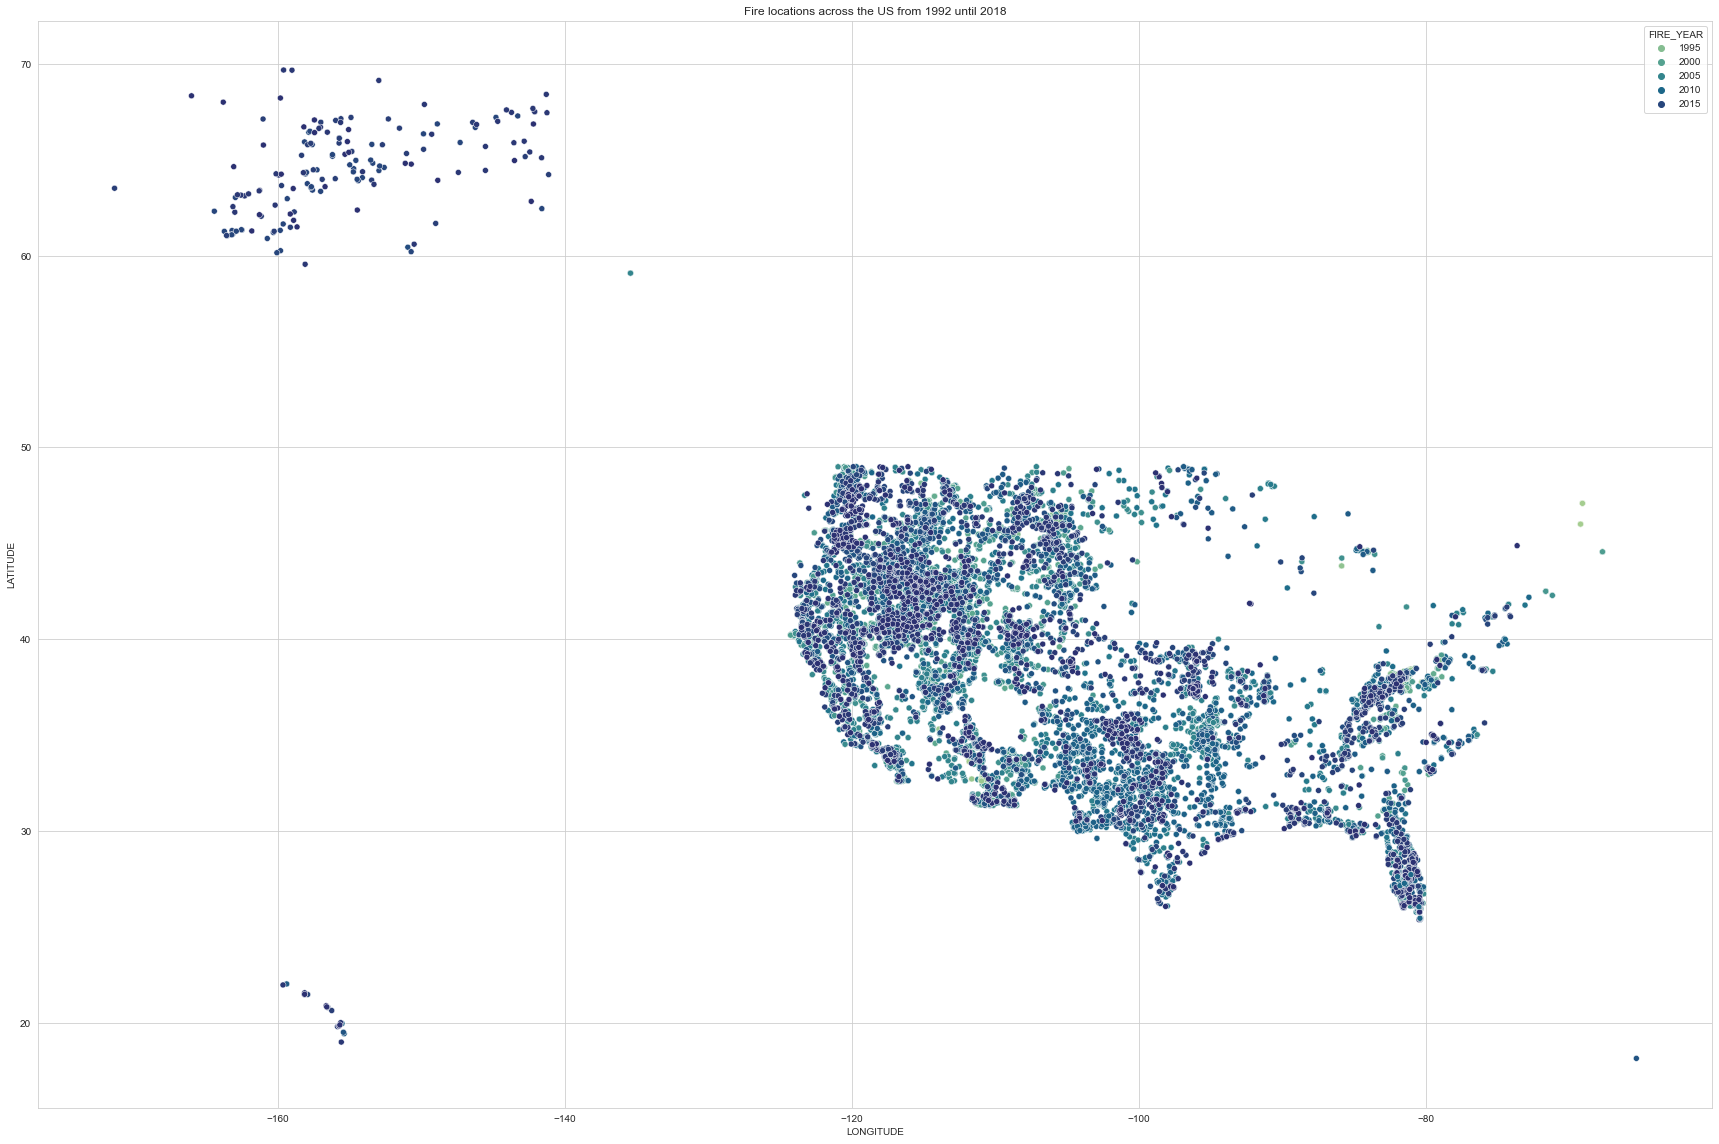

*The FIRE_YEAR legend refers to the year closing the respective ~5 year window represented by the colour.


In [8]:
#Plot latitude vs longitude with later years changing colour

span = df['FIRE_YEAR'].max() - df['FIRE_YEAR'].min()
stop1 = int(df['FIRE_YEAR'].min() + 5)
stop2 = int(df['FIRE_YEAR'].min() + 10)
stop3 = int(df['FIRE_YEAR'].min() + 15)
stop4 = int(df['FIRE_YEAR'].min() + 20)
stop5 = df['FIRE_YEAR'].max()

latlong = df[['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE_CLASS']].copy()
latlong['FIRE_YEAR'] = pd.to_numeric(latlong['FIRE_YEAR'])
latlong.drop(latlong[(latlong['FIRE_SIZE_CLASS']=='C')].index, inplace=True)
latlong.drop(latlong[(latlong['FIRE_SIZE_CLASS']=='D')].index, inplace=True)


one = pd.DataFrame(latlong.drop(latlong[(latlong['FIRE_YEAR']>stop1)].index))
two = pd.DataFrame(latlong.drop(latlong[(latlong['FIRE_YEAR']>stop2)].index))
three = pd.DataFrame(latlong.drop(latlong[(latlong['FIRE_YEAR']>stop3)].index))
four = pd.DataFrame(latlong.drop(latlong[(latlong['FIRE_YEAR']>stop4)].index))
five = pd.DataFrame(latlong.drop(latlong[(latlong['FIRE_YEAR']>stop5)].index))

concatenated = pd.concat([one.assign(dataset='set1'), two.assign(dataset='set2'), three.assign(dataset='set3'), four.assign(dataset='set4'), five.assign(dataset='set5')])


sns.set_style("whitegrid")
dims = (30, 20)
fig, ax = plt.subplots(figsize=dims)
sns.scatterplot(x='LONGITUDE', y='LATITUDE', data=concatenated, hue='FIRE_YEAR', palette = "crest")

plt.title('Fire locations across the US from 1992 until 2018')
plt.show()

print('*The FIRE_YEAR legend refers to the year closing the respective ~5 year window represented by the colour.')

While the plot does not provide as much detailed information as other more mathematical visualizations, we can see some of the same trends we have observed in our previous analyses:

    - The fires in the northernmost regions appear to have occurred at much later dates than southern.
    - In a roughly 5 year long period between 2005 and 2010 fires were much more common in the southern states, and show a much greater rate of occurrence.
    - Nothing can be said here about fire duration, but the lower number of fires in the south in the later years of the data may suggest southern fires simply lasted longer, and failed to be classified as new occurrences more often. Further analysis on fire duration should be done to support this.
    - Supporting an observation made in the final sections of the Exploratory Data analysis, we can see the fires only reached the northern and southernmost tips of the country such as Alaska and Hawaii in the last ten to fifteen years.
    
In conclusion, let's revisit my original research question:

**How has the location or frequency of wildfires in the US changed in the past 30 years, and does this show a potential correlation with climate change (ie. increasing temperatures)?**

With the graphics presented, we can be confident there have been some visible changes in US fires' statistics with regards to location. If the pattern continues as follows, we can expect another 5 years of increasing northern US fires in terms of frequency, and a steady maintenance of their duration. More broadly, the number of fire in the US seems to have drastically increased in the past 20-30 years. The western reguions of the continental US, while being widely burned in the past, continue to show a large number of fires every year, and the northern regions are showing long-lating fires, potentially due to the high forest density present in those areas. While the numbers continue to increase, and have taken a huge leap since the beginnign of this dataset in the early 90s, some data may suggest the increase has slowed down. The fact remains we are dealing with an enormous amount of fires, and most of the US continues to be burned every single year.

Now that we have seen a clear link between fires and their location within the US, we now ask ourselves what the cause of such fires is. 
Why is there such a visible change in the frequency, duration, and history of the fires across the country? 
Focusing on wildfires, an obvious answer may be increasing, or otherwise varying temperatures across noth america. To further study the changes in fires in the past 20-30 years, we will now pull a temperature database to help us back up our conclusions about the changing state of US fires.

In [2]:
dffinal = lnpb('C:/Users/Don/Desktop/FiresNEW.csv','C:/Users/Don/Desktop/csvData.csv','C:/Users/Don/Desktop/tavg.csv')
#CHANGE PATH FOR ALL 3 TO WHERE YOU DOWNLOAD THE FILE. FIRST FILE IS TOO LARGE TO USE IN GITHUB.

In [3]:
dffinal1 = dffinal.drop(dffinal[dffinal.index > 141].index)
dffinal2 = dffinal.drop(dffinal[(dffinal.index <= 141)].index)
dffinal2 = dffinal2.drop(dffinal2[(dffinal2.index > 248)].index)
dffinal3 = dffinal.drop(dffinal[(dffinal.index <= 248)].index)
dffinal3 = dffinal3.drop(dffinal3[(dffinal3.index > 372)].index)
dffinal4 = dffinal.drop(dffinal[(dffinal.index <= 372)].index)
dffinal4 = dffinal2.drop(dffinal2[(dffinal2.index > 512)].index)
dffinal5 = dffinal.drop(dffinal[(dffinal.index <= 512)].index)
dffinal5 = dffinal3.drop(dffinal3[(dffinal3.index > 658)].index)
dffinal6 = dffinal.drop(dffinal[(dffinal.index <= 658)].index)
dffinal6 = dffinal2.drop(dffinal2[(dffinal2.index > 793)].index)
dffinal7 = dffinal.drop(dffinal[(dffinal.index <= 793)].index)
dffinal7 = dffinal3.drop(dffinal3[(dffinal3.index > 932)].index)
dffinal8 = dffinal.drop(dffinal[dffinal.index <= 932].index)

#### Graph 1: Degrees Celsius vs # of Fires
For the first graph in my data analysis, I plotted a simple scatter plot of the total # of fires versus the Degrees in Celsius. This graph has point in almost all areas so it can be slightly tricky to read. If you look to the top right, this is where the hottest temperatures as well as the most fires are. Seeing this, I would definitely start to conclude that the temperature affects the amount of fires. There are some lower temeperature values with high fires, so this is interesting. My guess is that it is on the higher end of temperatures for the state it is in. I will try to explore this further in the next graphs.

Text(0, 0.5, 'Degrees Celsius')

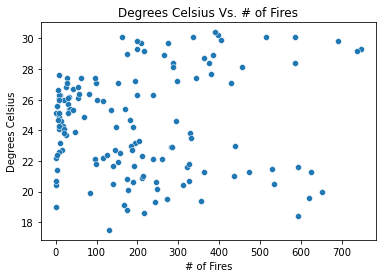

In [4]:
sns.scatterplot(x='# of Fires', y='Celsius',data = dffinal1)
plt.title('Degrees Celsius Vs. # of Fires')
plt.xlabel('# of Fires')
plt.ylabel('Degrees Celsius')

#### Graph 2: Degrees Celsius vs Year (Separated by State)
For these graphs, I used a facet grid of scatter plots to see the individual trends in temperature over the last 30 years. Although 30 years is not ideal since it is not a lot of data to interpret temperature change, in my opinion there is a slight upward trend for some of the states. This can be seen below, as a lot of states end up being slightly hotter in recent years than earlier years. This has to be taken with a grain of salt due to the short sample period.

([<matplotlib.axis.XTick at 0x1c88450a8b0>,
 [Text(3, 0, '1995'),
  Text(8, 0, '2000'),
  Text(13, 0, '2005'),
  Text(18, 0, '2010'),
  Text(23, 0, '2015')])

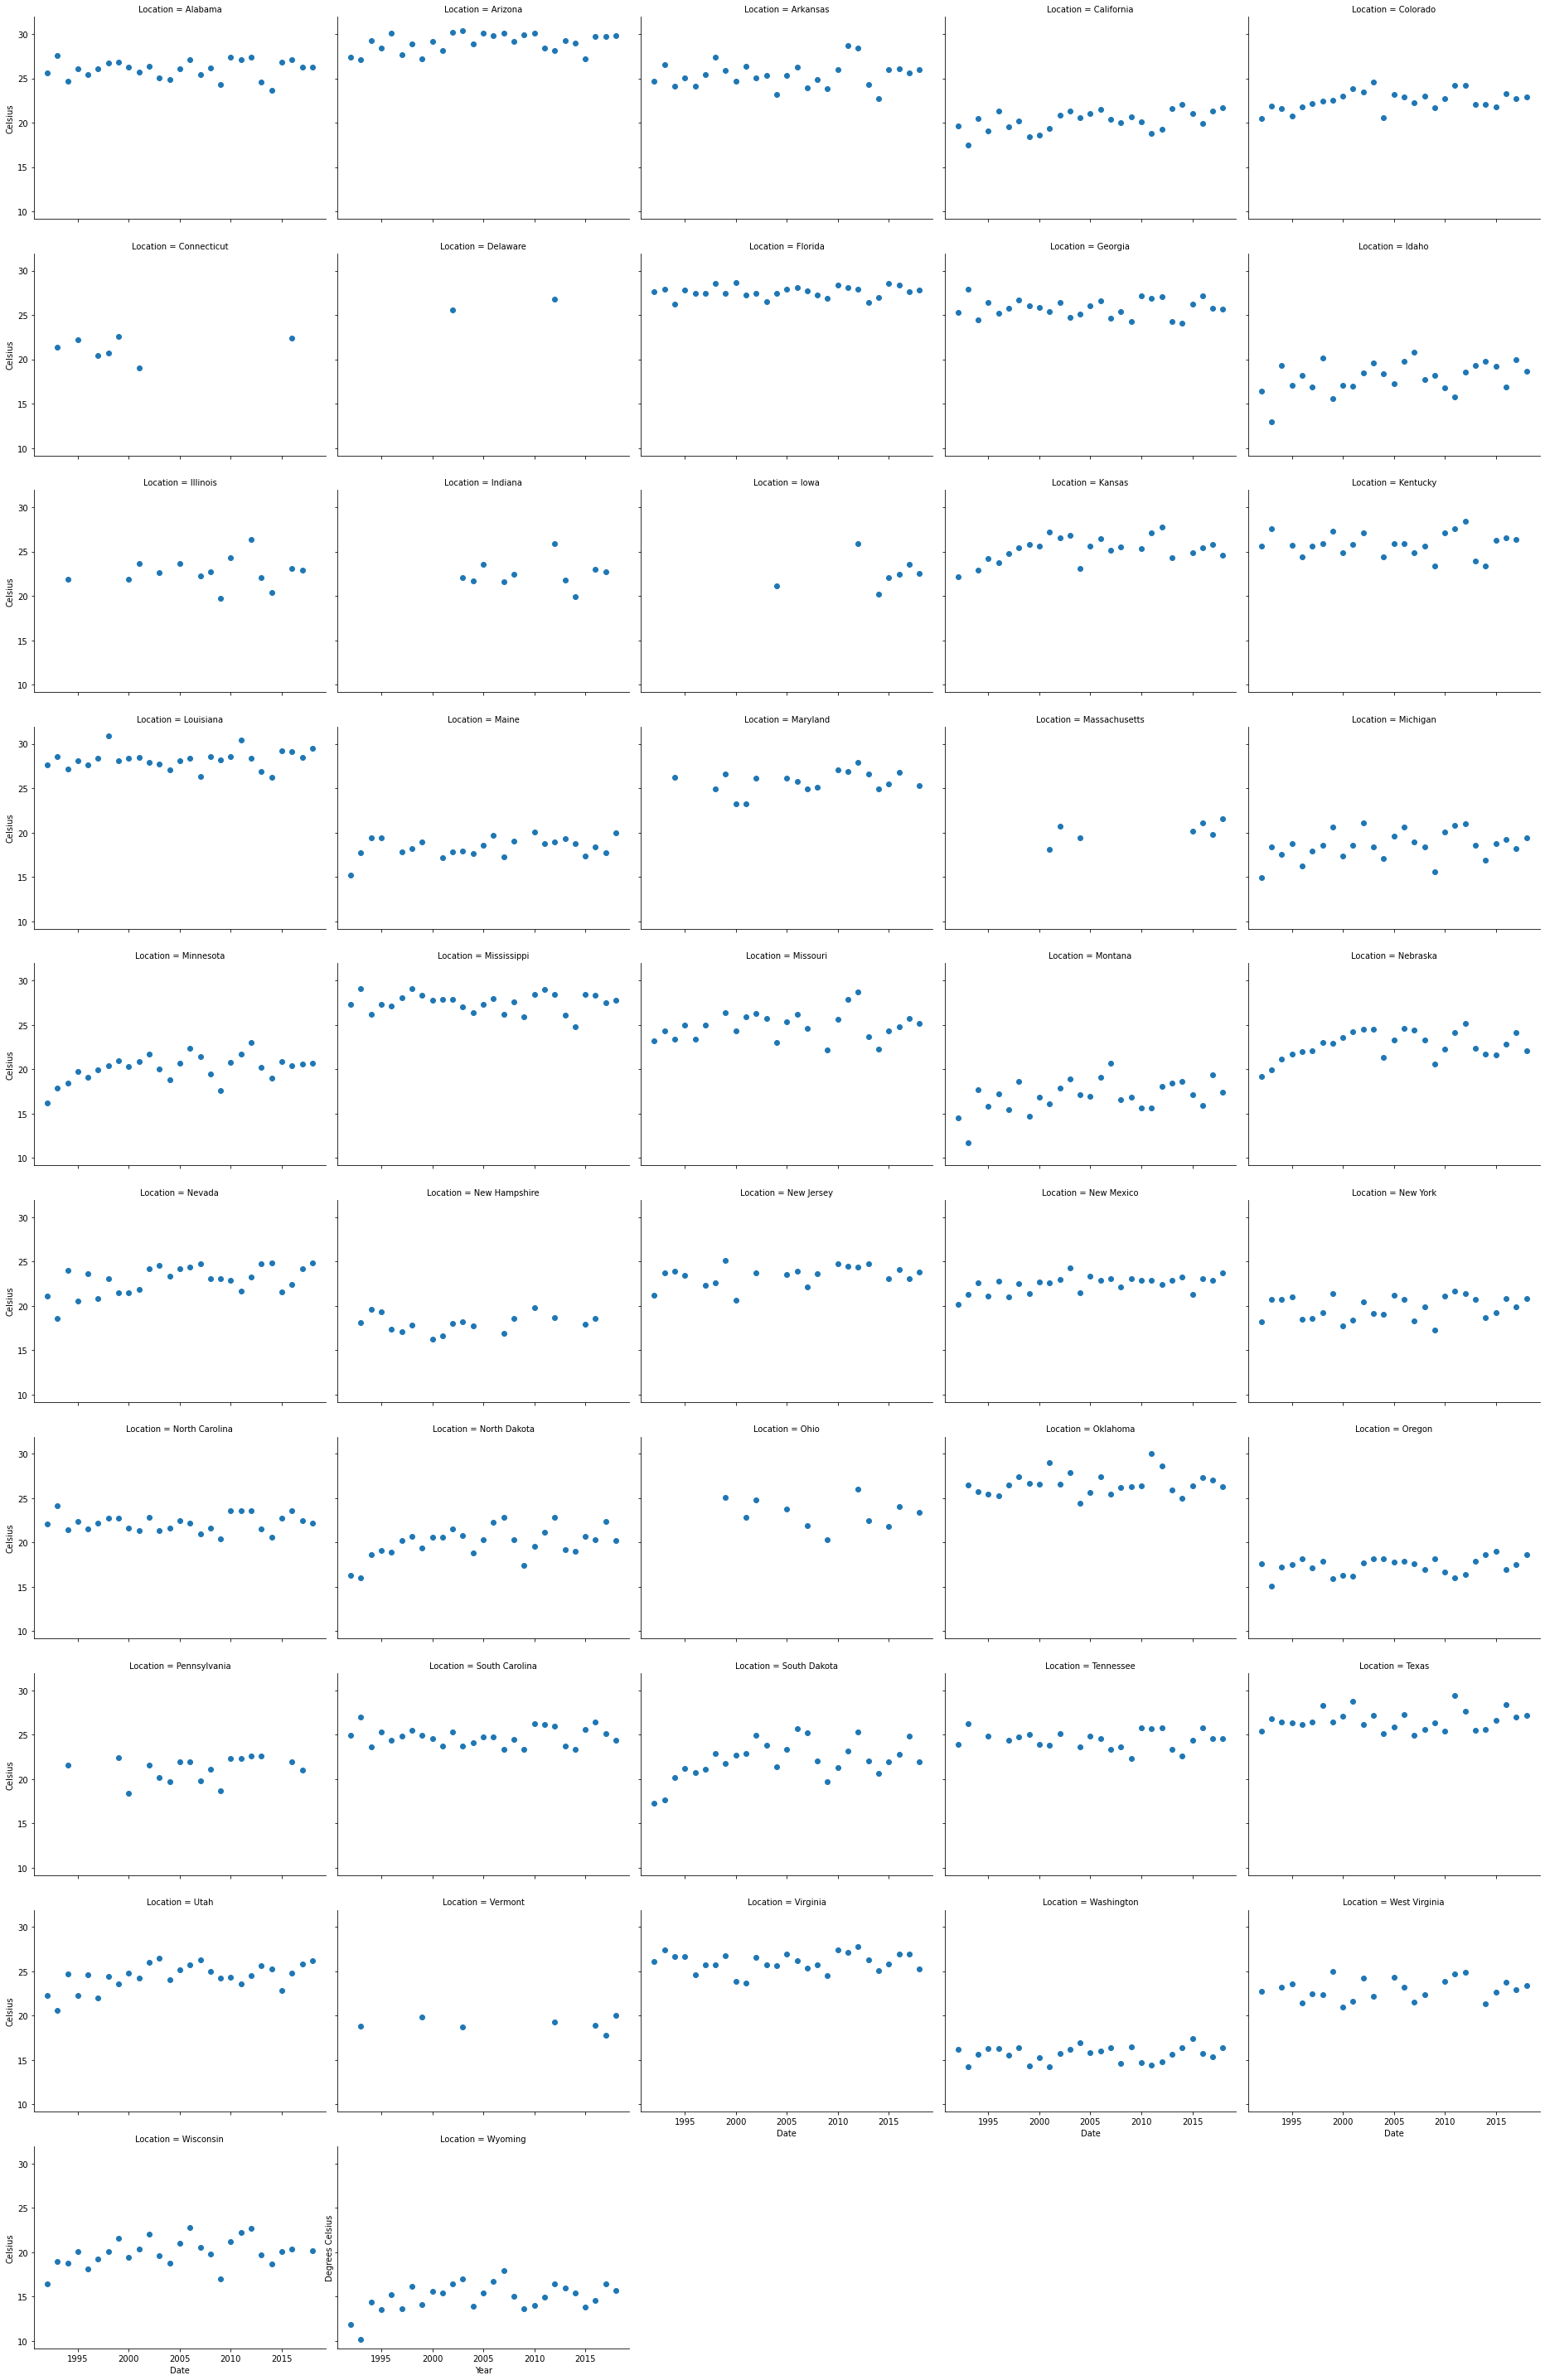

In [5]:
dfff = sns.FacetGrid(data = dffinal,col='Location',height=4,aspect=1.3,col_wrap=5)
dfff.map(plt.scatter,'Date','Celsius')
plt.xlabel('Year')
plt.ylabel('Degrees Celsius')
plt.xticks([3,8,13,18,23],[1995,2000,2005,2010,2015])

#### Graph 3: # of Fires vs Year (Separated by State)
For these graphs, I used a facet grid of scatter plots to see the individual trends in the number of fires over the last 30 years. Similar to the previous graphs, 30 years is not ideal since it is not a lot of data to interpret the change in pattern in fires. In my opinion there is a slight upward trend for some of the states. This can be seen below, as a lot of states end up being slightly hotter in recent years than earlier years. This has to be taken with a grain of salt due to the short sample period.

([<matplotlib.axis.XTick at 0x1c889668eb0>,
 [Text(3, 0, '1995'),
  Text(8, 0, '2000'),
  Text(13, 0, '2005'),
  Text(18, 0, '2010'),
  Text(23, 0, '2015')])

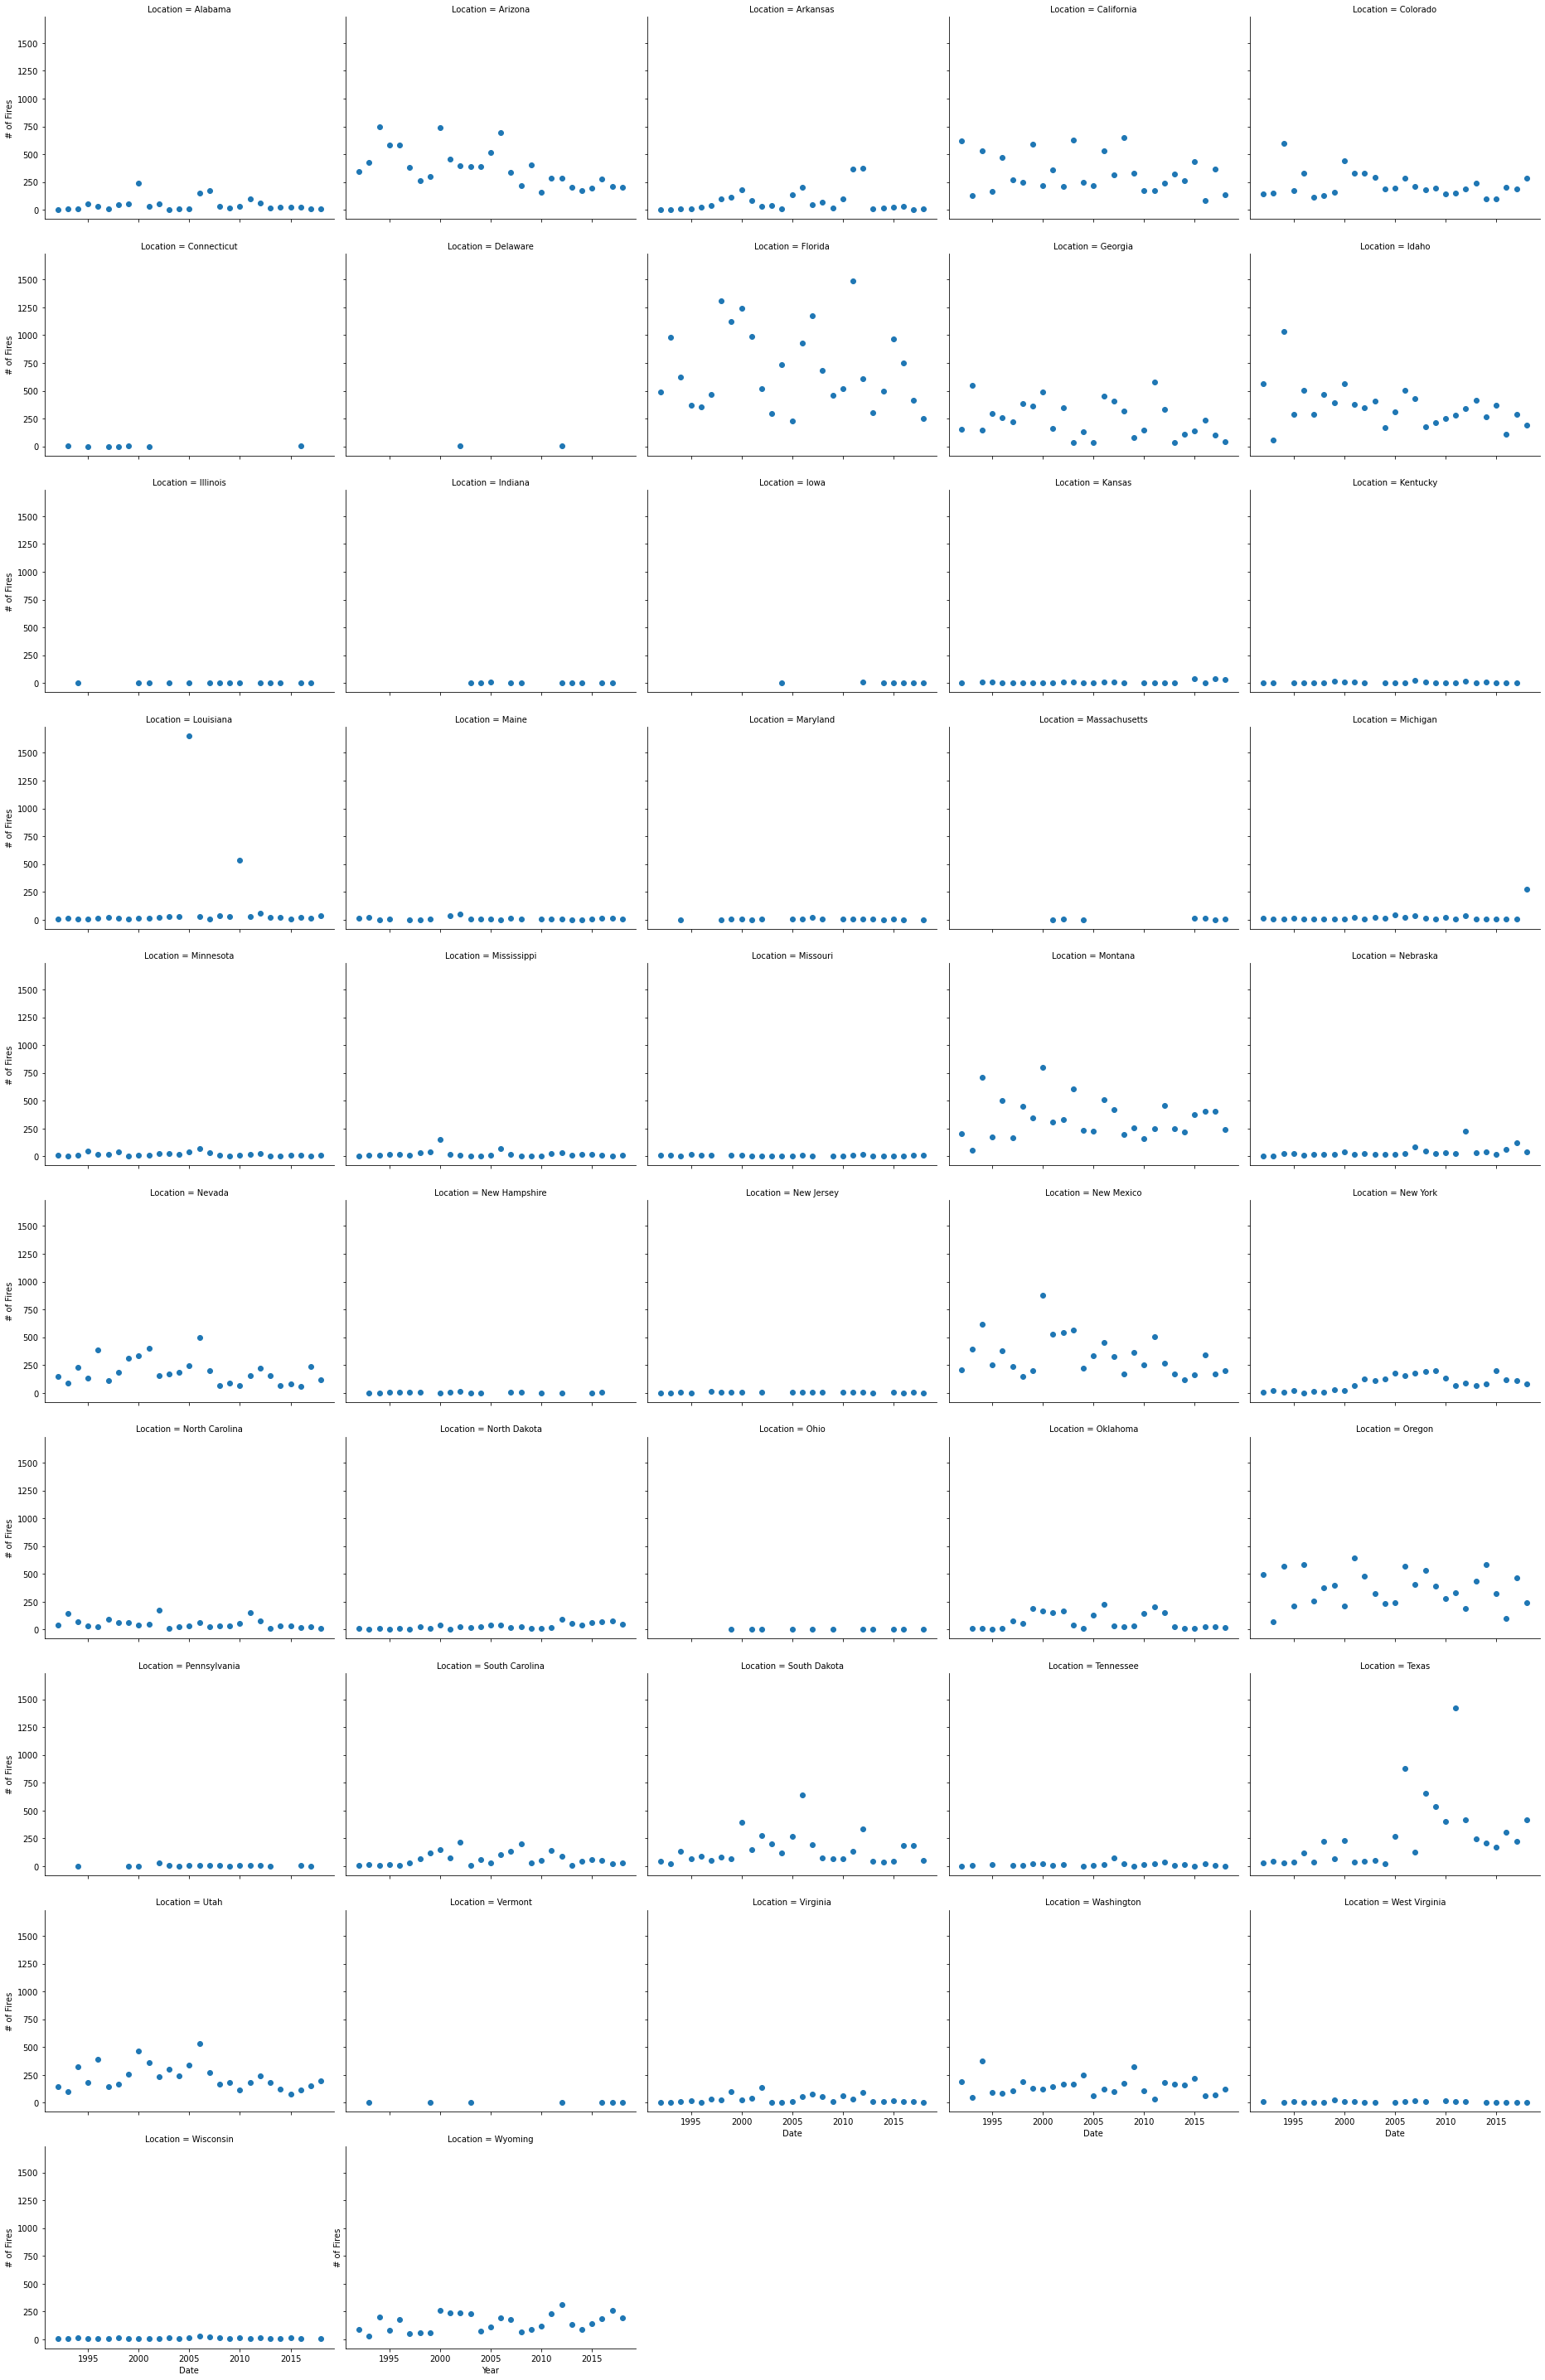

In [6]:
dfff = sns.FacetGrid(data = dffinal,col='Location',height=4,aspect=1.3,col_wrap=5)
dfff.map(plt.scatter,'Date','# of Fires')
plt.xlabel('Year')
plt.ylabel('# of Fires')
plt.xticks([3,8,13,18,23],[1995,2000,2005,2010,2015])

#### Graph 4: Degrees vs # of Fires (Separated by State)
For these graphs, I used a facet grid of scatter plots to see the individual trends in the number of fires over the last 30 years. Similar to the previous graphs, 30 years is not ideal since it is not a lot of data to interpret a pattern in the number of fires in comparison to to the temperature. However, after analyzing these graphs, I think it is possible to draw the ocnclusion that the temperature definitely affects the number of fires. For a lot of states, as the temperature increases, so does the amount of fires. This can be see nwell in Texas. Going up to the Temperature by year graph, we can see that the temperature increases over time. Moving onto the Fires by year graph, we can see that the amount of fires increased at roughly the same time period that the temperature increased. Finally. looking that this graph of Texas, you can see that as the temperature increases, so do the number of fires which helps demonstrate that the two variables are related.

Text(402.04, 0.5, 'Degrees Celsius')

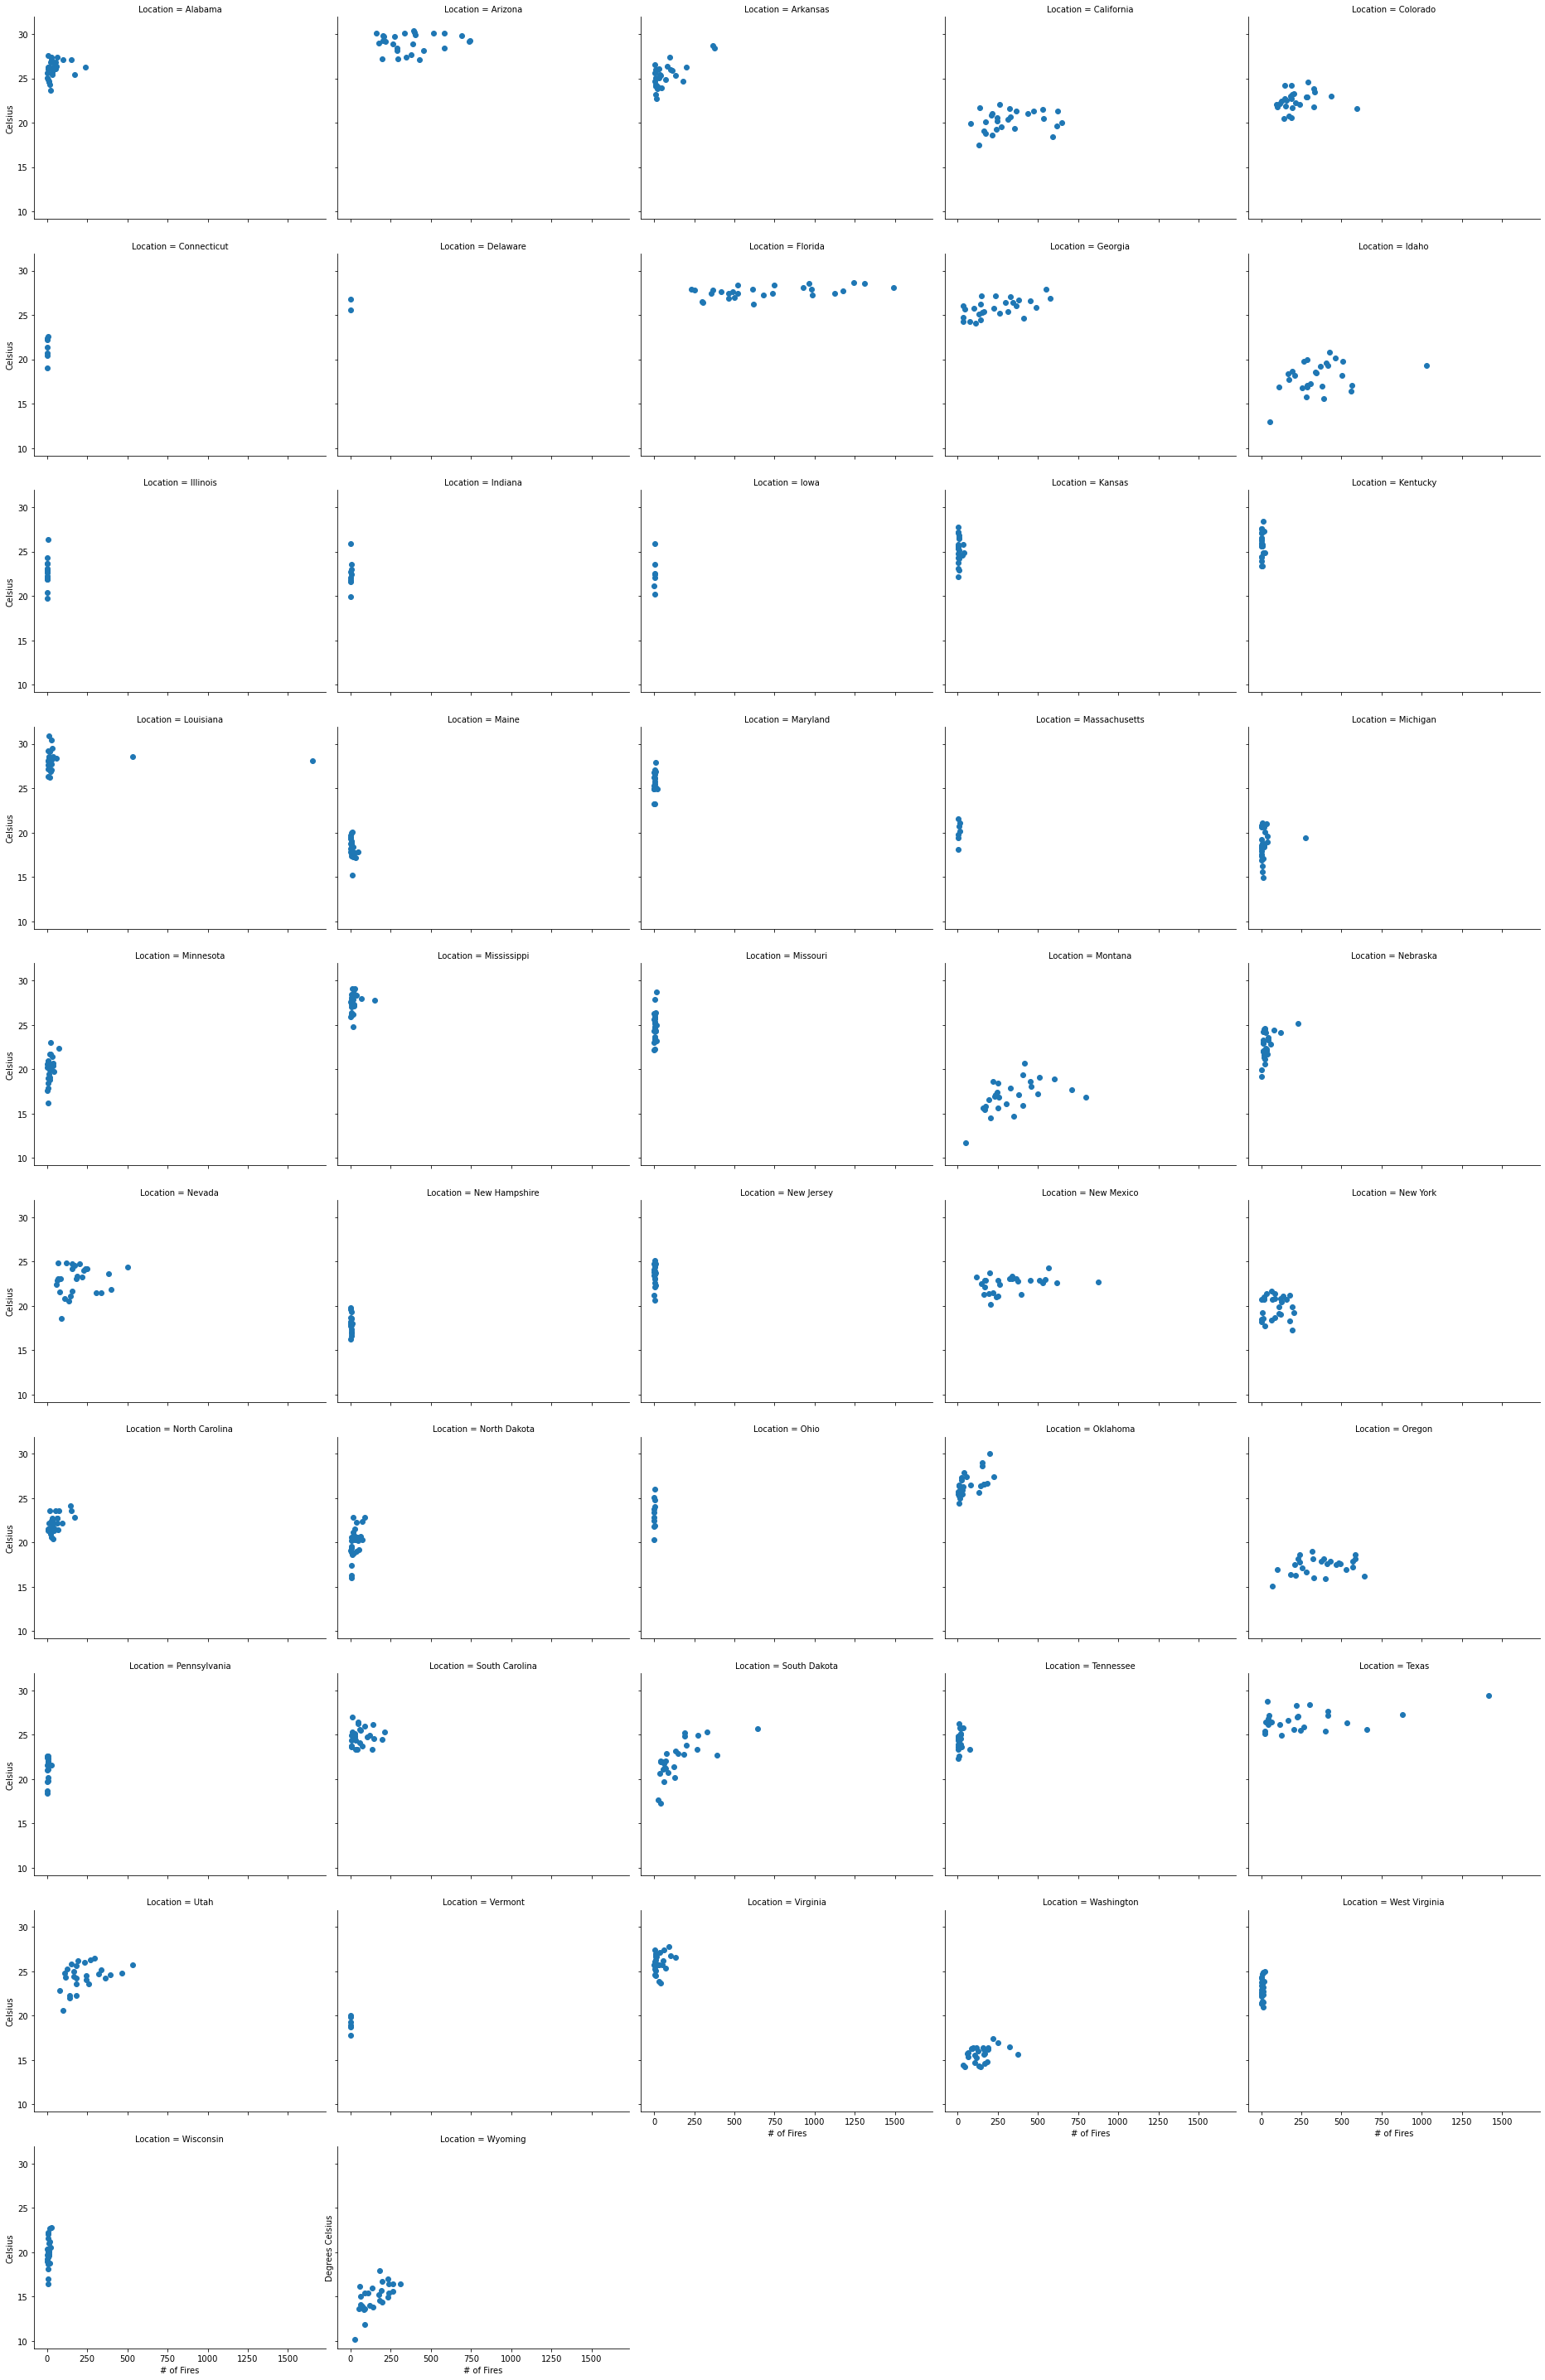

In [7]:
dfff = sns.FacetGrid(data = dffinal,col='Location',height=4,aspect=1.3,col_wrap=5)
dfff.map(plt.scatter,'# of Fires','Celsius')
plt.xlabel('# of Fires')
plt.ylabel('Degrees Celsius')


#### Graph 5: Celsius vs # of Fires
For this graph, I used a jointplot to demonstrate the spread of the degrees celsius versus the number of fires for the first 6 states alphabetically. This can be changed by rotating the dataframe from dffinal1 to dffinal8.It shows the distribution really well of how many fires are happening at each temperature. The temperature that most fires are happening is around 26 degrees celsius. This is definitely on the hotter end of some of the states. From the distributions, you can see that the # of fires might not exactly increase as the temperature rises, but there are definitely fires happening at higher tempeatures.

Text(29.0, 0.5, 'Degrees Celsius')

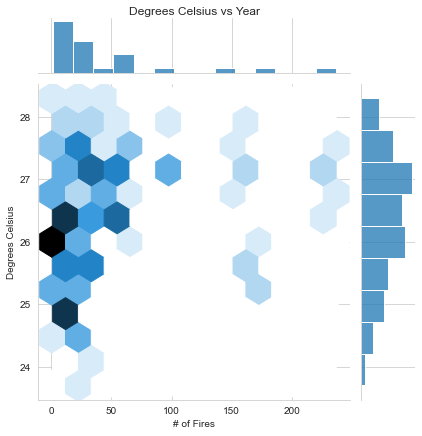

In [15]:
sns.jointplot(x='# of Fires', y='Celsius',data = dffinal1, kind='hex')
plt.title('Degrees Celsius vs Year',y=1.2)
plt.xlabel('# of Fires')
plt.ylabel('Degrees Celsius')


#### Graph 6: Celsius vs # of Fires
This is the same graph as plotted above, but using the kde format to display the data. It just provides a different way of interpreting the data.

Text(336.9714285714286, 0.5, 'Degrees Celsius')

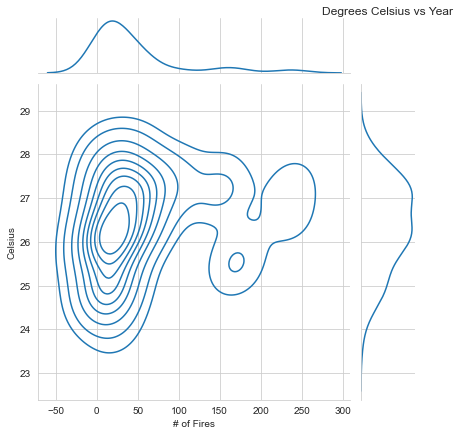

In [16]:
sns.jointplot(x='# of Fires', y='Celsius',data = dffinal1, kind='kde')
plt.title('Degrees Celsius vs Year',y=1.2)
plt.xlabel('# of Fires')
plt.ylabel('Degrees Celsius')


#### Graph 7: Location vs Degrees Celsius Heatmapped by # of Fires
For this graph, I wanted to demonstrate the amount of fires happening in each state by temperature. Since the last graphs were slightly biased by grouping states with different temperature averages, I figured a heat map would be best. After analyzing the data, it definitely is the best choice. You can see that for many states, as the temperature increases, so does the # of fires that happen in that state. The heatmap does a great job at displaying this and I will continue to use it for the next graphs.

Text(0.5, 15.0, 'Degrees Celsius')

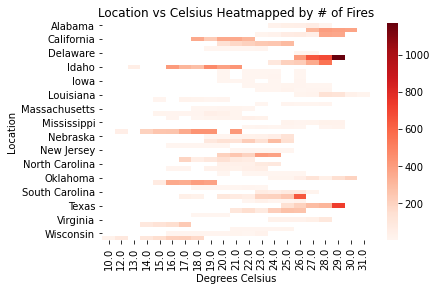

In [9]:
dffinalround = dffinal
dffinalround.Celsius = dffinal.Celsius.round(0)
fires = dffinalround.pivot_table(index='Location',columns='Celsius',values='# of Fires')
sns.heatmap(fires,cmap='Reds')
plt.title('Location vs Celsius Heatmapped by # of Fires')
plt.xlabel('Degrees Celsius')


#### Graph 8: Degrees Celsius vs Date Heatmapped by # of Fires
The intention of this graph was to see if the # of fires went up per year as the temperature increased. I think it does a good job at displaying that it does by looking at the top middle of the graph. The datk squares in the top middle and top right show that the number of fires increases with the temperature.

Text(33.0, 0.5, 'Degrees Celsius')

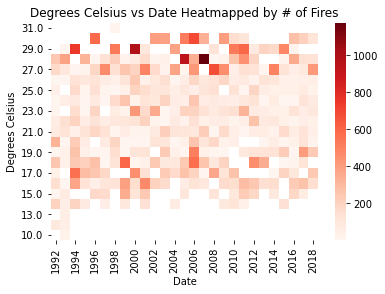

In [10]:
dffinalround = dffinal
dffinalround.Celsius = dffinal.Celsius.round(0)
fires = dffinal.pivot_table(index='Celsius',columns='Date',values='# of Fires')
ax = sns.heatmap(fires,cmap='Reds')
ax.invert_yaxis()
plt.title('Degrees Celsius vs Date Heatmapped by # of Fires')
plt.xlabel('Date')
plt.ylabel('Degrees Celsius')

#### Graph 9: Location vs # of Fires Heatmapped by Temperature
I feel that this graph is ideal to summarize what has been stated so far. By heatmapping it like this, you can see that the farther right you go for each state, the darker red the squares get. This means that when the number of fires in that state increase, so does the average temperature. I think that this can be seen in almost every state as seen below.

Text(32.99999999999999, 0.5, 'Location')

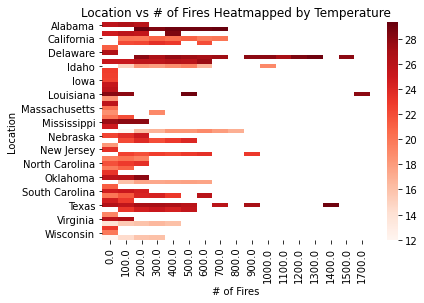

In [11]:
dffinalround['# of Fires'] = dffinal['# of Fires'].round(-2)
fires = dffinalround.pivot_table(index='Location',columns='# of Fires',values='Celsius')
sns.heatmap(fires,cmap='Reds')
plt.title('Location vs # of Fires Heatmapped by Temperature')
plt.xlabel('# of Fires')
plt.ylabel('Location')

#### Conclusion
In summary, I think that after analyzation of the data above, this helps confirm my research question that as the temperature increases globally due to climate change, the amount of forest fires that happen will also increase. I was able to draw this conclusion from many of my graphs, therefore I feel that the data is telling. To increase my certainty on conclusion, next time I would try to look for longer periods of data instead of 30 years. I would also use global locations instead of just the United States. This would help confirm my research question further by demonstrating as the temperature of the earth continues to rise due to climate change, so will the amount of forest fires that happen annually.